# Pulex Bucket: Search & Product Analysis

Analysis of "Pulex Bucket" search volume and specific product views from Oct 2025 to Jan 2026.

**Project:** `analytics-473719`  
**Dataset:** `analytics_306941895`

In [1]:
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

client = bigquery.Client(project="analytics-473719")
DATASET = "analytics_306941895"

## 1. Weekly Search Volume ("Pulex Bucket")
Counting internal site searches containing the term "pulex bucket".

In [2]:
sql_search = f"""
    SELECT
        DATE_TRUNC(PARSE_DATE('%Y%m%d', event_date), WEEK) as week,
        COUNT(*) as search_count
    FROM
        `analytics-473719.{DATASET}.events_*`
    WHERE
        event_name = 'view_search_results'
        AND LOWER((SELECT value.string_value FROM UNNEST(event_params) WHERE key = 'search_term')) LIKE '%pulex bucket%'
        AND _TABLE_SUFFIX BETWEEN '20240101' AND '20260201'  -- Covering full range
    GROUP BY
        week
    ORDER BY
        week ASC
"""

df_search = client.query(sql_search).to_dataframe()
df_search['week'] = pd.to_datetime(df_search['week'])
df_search.head()

/Users/maxhidalgo/projects/Google-Analytics/venv/lib/python3.14/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,week,search_count
0,2025-10-05,8
1,2025-10-12,9
2,2025-10-19,6
3,2025-10-26,19
4,2025-11-02,9


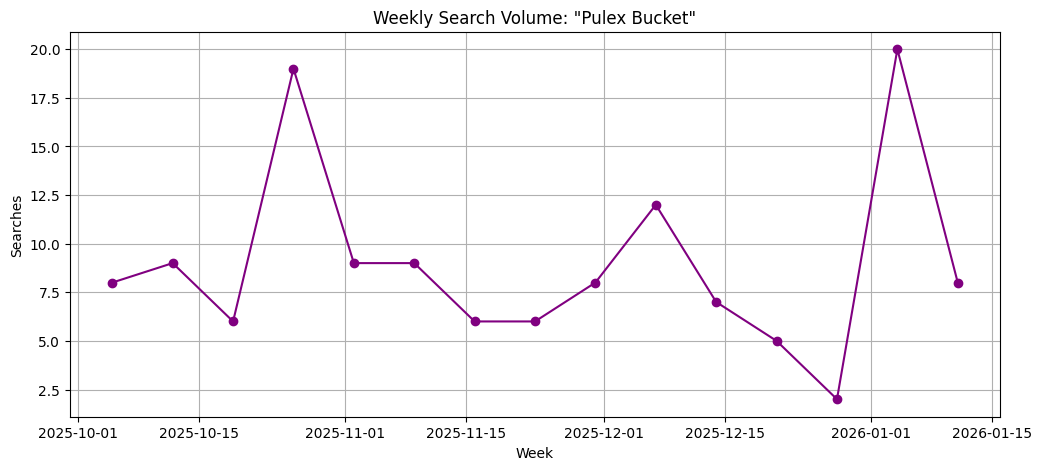

In [3]:
plt.figure(figsize=(12, 5))
plt.plot(df_search['week'], df_search['search_count'], marker='o', linestyle='-', color='purple')
plt.title('Weekly Search Volume: "Pulex Bucket"')
plt.xlabel('Week')
plt.ylabel('Searches')
plt.grid(True)
plt.show()

## 2. Weekly Product Views (Specific Colors)
Tracking views of individual "Pulex Bucket" product pages to see which specific items/colors are popular.

In [4]:
sql_items = f"""
    SELECT
        DATE_TRUNC(PARSE_DATE('%Y%m%d', event_date), WEEK) as week,
        item.item_name,
        COUNT(*) as views
    FROM
        `analytics-473719.{DATASET}.events_*`,
        UNNEST(items) as item
    WHERE
        event_name = 'view_item'
        AND LOWER(item.item_name) LIKE '%pulex bucket%'
        -- Identifying specific colors based on our discovery
        AND (
            item.item_name LIKE '%Red%'
            OR item.item_name LIKE '%Blue%'
            OR item.item_name LIKE '%Green%'
            OR item.item_name LIKE '%Gray%'
        )
        AND _TABLE_SUFFIX BETWEEN '20240101' AND '20260201'
    GROUP BY 1, 2
    ORDER BY 1 ASC, 3 DESC
"""

df_items = client.query(sql_items).to_dataframe()
df_items['week'] = pd.to_datetime(df_items['week'])
df_items.head()

/Users/maxhidalgo/projects/Google-Analytics/venv/lib/python3.14/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,week,item_name,views
0,2025-10-05,Pulex Bucket - Black and Blue,85
1,2025-10-05,Pulex Bucket Set - Green,62
2,2025-10-05,Pulex Bucket - Blue,33
3,2025-10-05,Pulex Bucket - Lime Green,24
4,2025-10-05,Pulex Bucket Lids - Gray,16


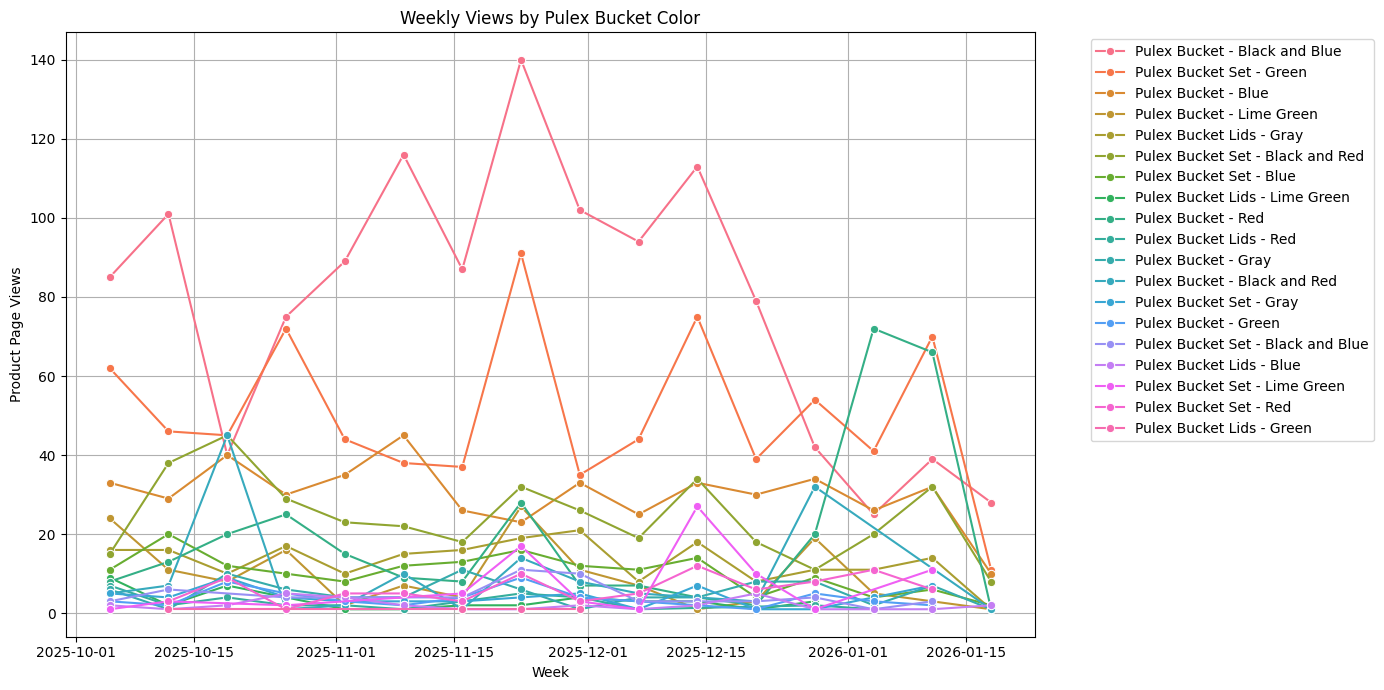

In [5]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=df_items, x='week', y='views', hue='item_name', marker='o')
plt.title('Weekly Views by Pulex Bucket Color')
plt.xlabel('Week')
plt.ylabel('Product Page Views')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import os
import pandas as pd
import plotly.express as px

def load_gsc_data(directory_path, label):
    """
    Loads GSC export data from the specified directory.
    Uses utf-8-sig to handle BOM and strips whitespace from column names.
    """
    data = {}
    
    # Helper to safely load csv
    def safe_load(filename):
        path = os.path.join(directory_path, filename)
        if os.path.exists(path):
            try:
                df = pd.read_csv(path, encoding='utf-8-sig')
            except UnicodeDecodeError:
                df = pd.read_csv(path, encoding='latin1')
            
            # Clean column names
            df.columns = df.columns.str.strip()
            df['Source'] = label
            return df
        else:
            print(f"Warning: {path} not found.")
            return None

    # Load Chart.csv
    df_chart = safe_load('Chart.csv')
    if df_chart is not None:
        if 'Date' in df_chart.columns:
            df_chart['Date'] = pd.to_datetime(df_chart['Date'])
        data['chart'] = df_chart
        
    # Load Queries.csv
    data['queries'] = safe_load('Queries.csv')

    # Load Pages.csv
    data['pages'] = safe_load('Pages.csv')
        
    return data

In [ ]:
# Defined paths
path_direct = "/Users/maxhidalgo/Downloads/Pulex-Bucket-Direct"
path_collection = "/Users/maxhidalgo/Downloads/Bucket-Collection"

# Load data
data_direct = load_gsc_data(path_direct, "Direct")
data_collection = load_gsc_data(path_collection, "Collection")

# Combine dataframes
def combine_data(key, d1, d2):
    dfs = []
    if d1.get(key) is not None: dfs.append(d1[key])
    if d2.get(key) is not None: dfs.append(d2[key])
    if dfs:
        return pd.concat(dfs, ignore_index=True)
    return pd.DataFrame()

df_chart_all = combine_data('chart', data_direct, data_collection)
df_queries_all = combine_data('queries', data_direct, data_collection)
df_pages_all = combine_data('pages', data_direct, data_collection)

print("Chart Data Shape:", df_chart_all.shape)
print("Chart Data Columns:", df_chart_all.columns.tolist())

In [ ]:
import plotly.express as px
import plotly.io as pio

# Force a renderer that doesn't require complex mime-type checks if default fails
pio.renderers.default = "iframe"

# Trend Analysis: Clicks and Impressions over time
if not df_chart_all.empty and 'Date' in df_chart_all.columns and 'Clicks' in df_chart_all.columns:
    try:
        # Clicks
        fig_clicks = px.line(df_chart_all, x='Date', y='Clicks', color='Source', title='GSC Clicks Over Time')
        fig_clicks.show()
        
        # Impressions
        fig_impressions = px.line(df_chart_all, x='Date', y='Impressions', color='Source', title='GSC Impressions Over Time')
        fig_impressions.show()
    except Exception as e:
        print(f"Error plotting: {e}")
else:
    print("Data for plotting is missing or incomplete.")

In [ ]:
# Top Queries by Clicks
if not df_queries_all.empty and 'Top queries' in df_queries_all.columns:
    print("Top Queries by Clicks (Direct):")
    print(df_queries_all[df_queries_all['Source'] == 'Direct'].sort_values(by='Clicks', ascending=False).head(10)[['Top queries', 'Clicks', 'Impressions', 'CTR', 'Position']])
    
    print("\nTop Queries by Clicks (Collection):")
    print(df_queries_all[df_queries_all['Source'] == 'Collection'].sort_values(by='Clicks', ascending=False).head(10)[['Top queries', 'Clicks', 'Impressions', 'CTR', 'Position']])
else:
    print("Queries data missing or column 'Top queries' not found.", df_queries_all.columns.tolist() if not df_queries_all.empty else "Empty DF")

In [ ]:
# Top Pages by Clicks
if not df_pages_all.empty and 'Top pages' in df_pages_all.columns:
    print("Top Pages by Clicks (Direct):")
    print(df_pages_all[df_pages_all['Source'] == 'Direct'].sort_values(by='Clicks', ascending=False).head(10)[['Top pages', 'Clicks', 'Impressions', 'CTR', 'Position']])
    
    print("\nTop Pages by Clicks (Collection):")
    print(df_pages_all[df_pages_all['Source'] == 'Collection'].sort_values(by='Clicks', ascending=False).head(10)[['Top pages', 'Clicks', 'Impressions', 'CTR', 'Position']])
else:
    print("Pages data missing or column 'Top pages' not found.", df_pages_all.columns.tolist() if not df_pages_all.empty else "Empty DF")